In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2 
import matplotlib.pyplot as plt
import numpy as np
from collect import collect
import seaborn as sns

In [2]:
# set fontsize
plt.rcParams.update({
    'text.usetex': True,            # Enable LaTeX for all text
    'font.family': 'sans-serif',         # Use LaTeX's default serif font
    'font.size': 9,                # Match your document font size
    'text.latex.preamble': r'''
        \usepackage{times}   
    ''',
})

sns.set_style("whitegrid", {
    'axes.edgecolor': 'black',    # Black border for the plot
    'grid.color': 'lightgray',   # Subtle gray gridlines
    'grid.linestyle': '--'       # Dashed gridlines for a modern look
})

legend_fontsize = 6.5
scale = 0.9

In [3]:
def batch_plot(data, color, alpha=.2, name=None, name_filter=None, x_axis='runtime', display_info=False, time_limit=None):
    x_lim = 1e100
    for run in data:
        if name_filter and not name_filter(run['name']):
            continue
        if run['state'] == 'crashed': continue
        history = run['history']
        if time_limit: history = history[history['_runtime'] < time_limit]
        if x_axis == 'runtime':
            x_data = history['_runtime']
        elif x_axis == 'iters':
            x_data = history['_step']
        y_data = history['loss']
        x_lim = min(x_lim, np.max(x_data))
        plt.plot(x_data, y_data, color=color, alpha=alpha, linewidth=0.8)

    x_grid  = np.linspace(0, x_lim, 300)
    loss_matrix = []
    losses, l2res, runtimes, names = [], [], [], []
    for run in data:
        if name_filter and not name_filter(run['name']):
            continue
        if run['state'] == 'crashed': continue
        history = run['history']
        if time_limit: history = history[history['_runtime'] < time_limit]
        if x_axis == 'runtime':
            x_data = history['_runtime']
        elif x_axis == 'iters':
            x_data = history['_step']
        names.append(run['name'])
        losses.append(history['loss'].iloc[-1])
        l2res.append(history['test/l2re'].iloc[-1])
        runtimes.append(history['_runtime'].iloc[-1])
        y_data = history['loss']
        loss_on_grid = np.interp(x_grid, x_data, y_data)
        loss_matrix.append(loss_on_grid)
    loss_matrix = np.vstack(loss_matrix)
    mean_loss = loss_matrix.mean(axis=0)
    std_loss = loss_matrix.std(axis=0)          # optional: uncertainty band
    plt.plot(x_grid, mean_loss, color=color, label=name)

    if display_info:
        print(names)
        print('  runtime = ', np.mean(runtimes), '±', np.std(runtimes) / np.sqrt(len(runtimes)))
        print('  loss (mean) = ', np.mean(losses), '±', np.std(losses) / np.sqrt(len(losses)))
        print('  loss (best) = ', np.min(losses))
        print('  l2re (mean) = ', np.mean(l2res), '±', np.std(l2res) / np.sqrt(len(l2res)))
        print('  l2re (best) = ', np.min(l2res))
        print('  total = ', len(l2res))


In [4]:
def plot_dual(data_nncg, data_adap, time_max, iter_max, mus = [(0.01, 'red')], display_suffix=True, time_limit=None):
    plt.figure(figsize=(6.9 * .91, 2.5 * .84))
    
    plt.subplot(121)
    #batch_plot(data_nncg, color='green', name=r'NNCG$_{0.1}$', name_filter=lambda s: 'mu-0.1' in s)
    for mu, color in mus:
        suffix = r"$_{" + str(mu) + r"}$" if display_suffix else ""
        batch_plot(data_nncg, color=color, name=f"NNCG{suffix}", name_filter=lambda s: f"mu-{mu}" in s, time_limit=time_limit)
    #batch_plot(data_nncg, color='', name=r'NNCG$_{0.001}$', name_filter=lambda s: 'mu-0.001' in s)
    batch_plot(data_adap, color='blue', name=r'ARNCG$_g$', time_limit=time_limit)
    plt.legend(fontsize=legend_fontsize)
    plt.xlabel('elapsed time (s)')
    plt.ylabel('training loss')
    plt.xlim([0, time_max])
    plt.yscale('log')
    
    plt.subplot(122)
    #batch_plot(data_nncg, color='green', name=r'NNCG$_{0.1}$', name_filter=lambda s: 'mu-0.1' in s, x_axis='iters')
    # batch_plot(data_nncg, color='red', name=r'NNCG$_{0.01}$', name_filter=lambda s: 'mu-0.01' in s, x_axis='iters')
    for mu, color in mus:
        suffix = r"$_{" + str(mu) + r"}$" if display_suffix else ""
        batch_plot(data_nncg, color=color, name=f"NNCG{suffix}", name_filter=lambda s: f"mu-{mu}" in s, x_axis='iters', display_info=True, time_limit=time_limit)
    #batch_plot(data_nncg, color='', name=r'NNCG$_{0.001}$', name_filter=lambda s: 'mu-0.001' in s, x_axis='iters')
    batch_plot(data_adap, color='blue', name=r'ARNCG$_g$', x_axis='iters', display_info=True, time_limit=time_limit)
    plt.legend(fontsize=legend_fontsize)
    plt.xlim(0, iter_max)
    plt.xlabel('number of iterations')
    plt.ylabel('training loss')
    plt.yscale('log')

In [5]:
def plot_right_fig(data_nncg, data_adap, time_max, iter_max, mus = [(0.01, 'red')], display_suffix=True, time_limit=None):
    plt.figure(figsize=(6.9 * .91 / 2, 2.5 * .84))
    
    #batch_plot(data_nncg, color='green', name=r'NNCG$_{0.1}$', name_filter=lambda s: 'mu-0.1' in s, x_axis='iters')
    # batch_plot(data_nncg, color='red', name=r'NNCG$_{0.01}$', name_filter=lambda s: 'mu-0.01' in s, x_axis='iters')
    for mu, color in mus:
        suffix = r"$_{" + str(mu) + r"}$" if display_suffix else ""
        batch_plot(data_nncg, color=color, name=f"NNCG{suffix}", name_filter=lambda s: f"mu-{mu}" in s, x_axis='iters', display_info=True, time_limit=time_limit)
    #batch_plot(data_nncg, color='', name=r'NNCG$_{0.001}$', name_filter=lambda s: 'mu-0.001' in s, x_axis='iters')
    batch_plot(data_adap, color='blue', name=r'ARNCG$_g$', x_axis='iters', display_info=True, time_limit=time_limit)
    plt.legend(fontsize=legend_fontsize)
    plt.xlim(0, iter_max)
    plt.xlabel('number of iterations')
    plt.ylabel('training loss')
    plt.yscale('log')

In [6]:
def plot_vertical(adam, lbfgs, final):
    plt.axvline(adam, color="black", linestyle="--", lw=1, alpha=0.8)
    plt.axvline(lbfgs, color="black", linestyle="--", lw=1, alpha=0.8)
    
    # (optional) annotate the stages
    y_top = plt.ylim()[1]
    plt.text(adam * .5, y_top, r"Adam", #rotation=90,
             ha="center", va="bottom", fontsize=legend_fontsize)
    plt.text(adam + 0.5 * (lbfgs - adam), y_top, r"L‑BFGS", # rotation=90,
             ha="center", va="bottom", fontsize=legend_fontsize)
    plt.text(lbfgs + 0.5 * (final - lbfgs), y_top, r"NNCG / ARNCG", # rotation=90,
             ha="center", va="bottom", fontsize=legend_fontsize)

In [7]:
reaction_adap = collect('p100_yuhao_fp64_tm_reaction_adam-lbfgs-adap_1000-3000_logger')
reaction_nncg = collect('p100_yuhao_fp64_tm_reaction_adam-lbfgs-nncg_1000-3000_logger')

['adam-lbfgs-nncg_nncg-mu-0.1_seed-2', 'adam-lbfgs-nncg_nncg-mu-0.1_seed-7', 'adam-lbfgs-nncg_nncg-mu-0.1_seed-3', 'adam-lbfgs-nncg_nncg-mu-0.1_seed-6', 'adam-lbfgs-nncg_nncg-mu-0.1_seed-5', 'adam-lbfgs-nncg_nncg-mu-0.1_seed-1', 'adam-lbfgs-nncg_nncg-mu-0.1_seed-4', 'adam-lbfgs-nncg_nncg-mu-0.1_seed-0']
  runtime =  7216.577133208513 ± 2.983762926471004
  loss (mean) =  3.0308429379397215e-07 ± 7.601980545829886e-08
  loss (best) =  1.1146471005005894e-07
  l2re (mean) =  0.010875022758199694 ± 0.0011642072255060915
  l2re (best) =  0.004685058386018688
  total =  8
['adam-lbfgs-nncg_nncg-mu-0.01_seed-3', 'adam-lbfgs-nncg_nncg-mu-0.01_seed-7', 'adam-lbfgs-nncg_nncg-mu-0.01_seed-4', 'adam-lbfgs-nncg_nncg-mu-0.01_seed-0', 'adam-lbfgs-nncg_nncg-mu-0.01_seed-5', 'adam-lbfgs-nncg_nncg-mu-0.01_seed-2', 'adam-lbfgs-nncg_nncg-mu-0.01_seed-1', 'adam-lbfgs-nncg_nncg-mu-0.01_seed-6']
  runtime =  7214.3938328027725 ± 1.946382018498972
  loss (mean) =  5.198477844455566e-08 ± 1.1138877132354722e-0

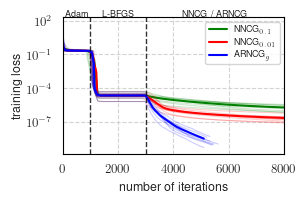

In [8]:
#plot_right_fig(reaction_nncg, reaction_adap, 7200, 8000, display_suffix=False)
plot_right_fig(reaction_nncg, reaction_adap, 7200, 8000, mus=[(0.1, 'green'), (0.01, 'red')])
plot_vertical(1000, 3000, 8000)
plt.tight_layout()
plt.savefig('pinn-reaction-it.pdf', bbox_inches='tight', pad_inches=0.05)

['adam-lbfgs-nncg_nncg-mu-0.1_seed-2', 'adam-lbfgs-nncg_nncg-mu-0.1_seed-7', 'adam-lbfgs-nncg_nncg-mu-0.1_seed-3', 'adam-lbfgs-nncg_nncg-mu-0.1_seed-6', 'adam-lbfgs-nncg_nncg-mu-0.1_seed-5', 'adam-lbfgs-nncg_nncg-mu-0.1_seed-1', 'adam-lbfgs-nncg_nncg-mu-0.1_seed-4', 'adam-lbfgs-nncg_nncg-mu-0.1_seed-0']
  runtime =  7216.577133208513 ± 2.983762926471004
  loss (mean) =  3.0308429379397215e-07 ± 7.601980545829886e-08
  loss (best) =  1.1146471005005894e-07
  l2re (mean) =  0.010875022758199694 ± 0.0011642072255060915
  l2re (best) =  0.004685058386018688
  total =  8
['adam-lbfgs-nncg_nncg-mu-0.01_seed-3', 'adam-lbfgs-nncg_nncg-mu-0.01_seed-7', 'adam-lbfgs-nncg_nncg-mu-0.01_seed-4', 'adam-lbfgs-nncg_nncg-mu-0.01_seed-0', 'adam-lbfgs-nncg_nncg-mu-0.01_seed-5', 'adam-lbfgs-nncg_nncg-mu-0.01_seed-2', 'adam-lbfgs-nncg_nncg-mu-0.01_seed-1', 'adam-lbfgs-nncg_nncg-mu-0.01_seed-6']
  runtime =  7214.3938328027725 ± 1.946382018498972
  loss (mean) =  5.198477844455566e-08 ± 1.1138877132354722e-0

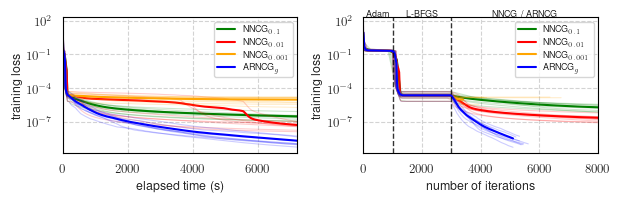

In [9]:
plot_dual(reaction_nncg, reaction_adap, 7200, 8000, mus=[(0.1, 'green'), (0.01, 'red'), (0.001, 'orange')])
plot_vertical(1000, 3000, 8000)
plt.tight_layout()
plt.savefig('pinn-reaction-full.pdf', bbox_inches='tight', pad_inches=0.05)

In [58]:
convection_adap = collect('p100_yuhao_fp64_tm_convection_adam-lbfgs-adap_11000-12500_logger')
convection_nncg = collect('p100_yuhao_fp64_tm_convection_adam-lbfgs-nncg_11000-12500_logger', use_cache=False)

['adam-lbfgs-nncg_nncg-mu-0.1_seed-5', 'adam-lbfgs-nncg_nncg-mu-0.1_seed-4', 'adam-lbfgs-nncg_nncg-mu-0.1_seed-1', 'adam-lbfgs-nncg_nncg-mu-0.1_seed-7', 'adam-lbfgs-nncg_nncg-mu-0.1_seed-3', 'adam-lbfgs-nncg_nncg-mu-0.1_seed-6', 'adam-lbfgs-nncg_nncg-mu-0.1_seed-0', 'adam-lbfgs-nncg_nncg-mu-0.1_seed-2']
  runtime =  26949.825669050217 ± 38.03099603634639
  loss (mean) =  3.3546173603398583e-07 ± 4.609268350564946e-08
  loss (best) =  1.1715125686957088e-07
  l2re (mean) =  0.0028533949401800514 ± 0.0003759473736398268
  l2re (best) =  0.0005688444784434491
  total =  8
['adam-lbfgs-nncg_nncg-mu-0.01_seed-5', 'adam-lbfgs-nncg_nncg-mu-0.01_seed-7', 'adam-lbfgs-nncg_nncg-mu-0.01_seed-3', 'adam-lbfgs-nncg_nncg-mu-0.01_seed-6', 'adam-lbfgs-nncg_nncg-mu-0.01_seed-2', 'adam-lbfgs-nncg_nncg-mu-0.01_seed-4', 'adam-lbfgs-nncg_nncg-mu-0.01_seed-1', 'adam-lbfgs-nncg_nncg-mu-0.01_seed-0']
  runtime =  27000.284339398146 ± 13.872796127893228
  loss (mean) =  8.900019651358706e-08 ± 1.502657882087202

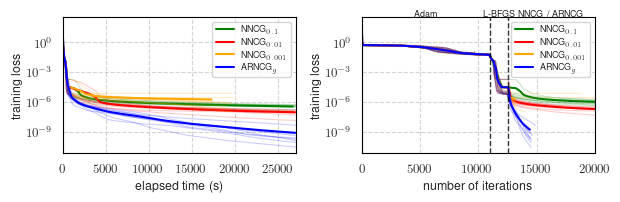

In [59]:
convection_iters = 20000
plot_dual(convection_nncg, convection_adap, 27000, convection_iters, mus=[(0.1, 'green'), (0.01, 'red'), (0.001, 'orange')])
plot_vertical(11000, 12500, convection_iters)
plt.tight_layout()
plt.savefig('pinn-convection-full.pdf', bbox_inches='tight', pad_inches=0.05)

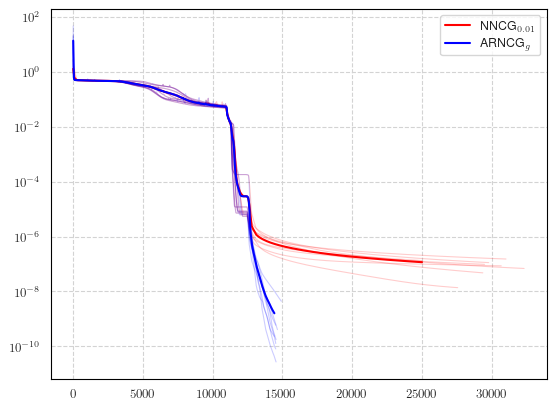

In [40]:
#batch_plot(convection_nncg, color='green', name=r'NNCG$_{0.1}$', name_filter=lambda s: 'mu-0.1' in s)
batch_plot(convection_nncg, color='red', name=r'NNCG$_{0.01}$', name_filter=lambda s: 'mu-0.01' in s, x_axis='iters')
#batch_plot(reaction_nncg, color='', name=r'NNCG$_{0.001}$', name_filter=lambda s: 'mu-0.001' in s)
batch_plot(convection_adap, color='blue', name=r'ARNCG$_g$', x_axis='iters')
plt.legend()
plt.yscale('log')

In [13]:
wave_adap = collect('4090_bingrui_wave_adam-lbfgs-adap_1000-3000_float64-v1')
wave_nncg = collect('4090_bingrui_wave_adam-lbfgs-nncg_1000-3000_fp64_v2')
wave_nncg.extend(collect('4090_bingrui_wave_adam-lbfgs-nncg_1000-3000_fp64_v0'))

['adam-lbfgs-nncg_nncg-mu-0.1_seed-3', 'adam-lbfgs-nncg_nncg-mu-0.1_seed-0', 'adam-lbfgs-nncg_nncg-mu-0.1_seed-1', 'adam-lbfgs-nncg_nncg-mu-0.1_seed-6', 'adam-lbfgs-nncg_nncg-mu-0.1_seed-4', 'adam-lbfgs-nncg_nncg-mu-0.1_seed-7', 'adam-lbfgs-nncg_nncg-mu-0.1_seed-2', 'adam-lbfgs-nncg_nncg-mu-0.1_seed-5']
  runtime =  155134.3714171052 ± 14097.620204288452
  loss (mean) =  0.0030642426718109302 ± 0.0012373561733262832
  loss (best) =  0.00010140477509965339
  l2re (mean) =  0.0931129574900167 ± 0.028264560305469776
  l2re (best) =  0.014764799417584544
  total =  8
['adam-lbfgs-nncg_nncg-mu-0.01_seed-2', 'adam-lbfgs-nncg_nncg-mu-0.01_seed-5', 'adam-lbfgs-nncg_nncg-mu-0.01_seed-4', 'adam-lbfgs-nncg_nncg-mu-0.01_seed-0', 'adam-lbfgs-nncg_nncg-mu-0.01_seed-7', 'adam-lbfgs-nncg_nncg-mu-0.01_seed-1', 'adam-lbfgs-nncg_nncg-mu-0.01_seed-6', 'adam-lbfgs-nncg_nncg-mu-0.01_seed-3']
  runtime =  210899.47399172187 ± 916.9940922143173
  loss (mean) =  0.00044025873309485046 ± 0.00030928298007972194


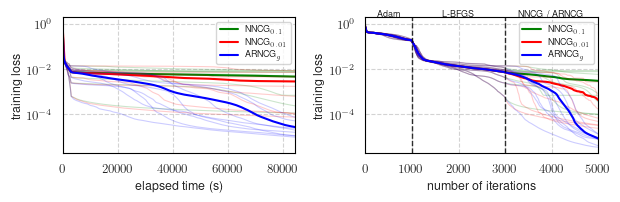

In [53]:
wave_max_iters = 5000
plot_dual(wave_nncg, wave_adap, 3600 * 23.5, 5000, mus=[(0.1, 'green'), (0.01, 'red')], time_limit=3600 * 96)
plot_vertical(1000, 3000, wave_max_iters)
plt.tight_layout()
#plt.savefig('pinn-wave-full-4090.pdf', bbox_inches='tight', pad_inches=0.05)

In [60]:
wave_adap_p100 = collect('p100_yuhao_fp64_tm2_wave_adam-lbfgs-adap_1000-3000_logger') #, use_cache=False)
wave_nncg_p100 = collect('p100_yuhao_fp64_tm_wave_adam-lbfgs-nncg_1000-3000_logger', use_cache=False)

['adam-lbfgs-nncg_nncg-mu-0.1_seed-0', 'adam-lbfgs-nncg_nncg-mu-0.1_seed-6', 'adam-lbfgs-nncg_nncg-mu-0.1_seed-2', 'adam-lbfgs-nncg_nncg-mu-0.1_seed-7', 'adam-lbfgs-nncg_nncg-mu-0.1_seed-4', 'adam-lbfgs-nncg_nncg-mu-0.1_seed-3', 'adam-lbfgs-nncg_nncg-mu-0.1_seed-1', 'adam-lbfgs-nncg_nncg-mu-0.1_seed-5']
  runtime =  87081.67262926698 ± 162.01365146622823
  loss (mean) =  0.0022574016009663366 ± 0.0010590441234486288
  loss (best) =  0.00015970050245526018
  l2re (mean) =  0.07536796545285693 ± 0.023012227180507647
  l2re (best) =  0.02149515712841968
  total =  8
['adam-lbfgs-nncg_nncg-mu-0.01_seed-3', 'adam-lbfgs-nncg_nncg-mu-0.01_seed-4', 'adam-lbfgs-nncg_nncg-mu-0.01_seed-2', 'adam-lbfgs-nncg_nncg-mu-0.01_seed-7', 'adam-lbfgs-nncg_nncg-mu-0.01_seed-1', 'adam-lbfgs-nncg_nncg-mu-0.01_seed-6', 'adam-lbfgs-nncg_nncg-mu-0.01_seed-5', 'adam-lbfgs-nncg_nncg-mu-0.01_seed-0']
  runtime =  86915.06050783396 ± 38.01308671268627
  loss (mean) =  0.001884008391582829 ± 0.0009563367092665204
  lo

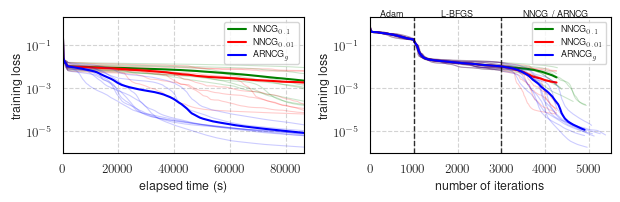

In [61]:
wave_max_iters = 5500
#plot_dual(wave_nncg_p100, wave_adap_p100, 3600 * 18 - 1800, wave_max_iters, time_limit=64800, mus=[(0.1, 'green'), (0.01, 'red')])
plot_dual(wave_nncg_p100, wave_adap_p100, 3600 * 24, wave_max_iters, mus=[(0.1, 'green'), (0.01, 'red')])
plot_vertical(1000, 3000, wave_max_iters)
plt.tight_layout()
plt.savefig('pinn-wave-full.pdf', bbox_inches='tight', pad_inches=0.05)